# MAJ
1. Test CPRAND (err_rand_fast) : on a un facteur de 3 par rapport aux vraies erreurs
2. Modification herCPRAND (partie calcul error) : aussi facteur de 3
3. Tracer les 4 algorithmes sur un même graph (cf Comparaison of algorithms)
4. Nombre de restart : mais on tombre toujours dans le cas où F_hat_new>F_hat_bf ?

In [1]:
pip install -U tensorly

Requirement already up-to-date: tensorly in /home/jecohen/.local/lib/python3.7/site-packages (0.5.0)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
from tensorly.decomposition import sample_khatri_rao
from scipy.optimize import linear_sum_assignment
from statistics import median
import time

# Decomposition

### ALS

In [3]:
# stopping criteria 
def err(tensor,weight,factors): 
  t_tilde=tl.kruskal_to_tensor((weight,factors)) # transform tensor decomposition (kruskal tensor) to tensor
  return(tl.norm(tensor-t_tilde))

In [4]:
def err_fast(norm_tensor,A,V,W):
  res=sum(sum(V*(np.transpose(A).dot(A))))
  res=res-2*sum(sum(W*A))
  return(np.sqrt(norm_tensor**2+res))

In [5]:
def err_fac(fac,fac_est) :
  weights,fac=tl.cp_normalize((None,fac))
  weights_est,fac_est=tl.cp_normalize((None,fac_est))
  err=0
  for i in range(len(fac)):
    row_ind, col_ind = linear_sum_assignment(-np.dot(np.transpose(fac[i]),fac_est[i]))
    err=err+(tl.norm(fac[i]-fac_est[i][:,col_ind])/tl.norm(fac[i]))
  return(err/len(fac))

A = np.random.rand(4,2)
B = np.random.rand(4,2)
C = np.random.rand(4,2)

Ap = A[:,[1,0]]
Bp = B[:,[1,0]]
Cp = C[:,[1,0]]

err_fac([A,B,C],[Ap,Bp,Cp])

0.0

In [6]:
# Moved up to be able to run the notebook
def init_factors(I,J,K,r,scale=False) :
  A=np.random.normal(0, 1, size=(I, r))
  B=np.random.normal(0, 1, size=(J, r))
  C=np.random.normal(0, 1, size=(K, r))
  # Noise level should also be an imput, in case you want more noise. 
  # I would actually not chose noise as a random variable, rather as something deterministic.
  noise=np.random.normal(0, 0.001, size=(I,J,K))
  if (scale==True) :  
    A=sv_scale_to_100(A)
    B=sv_scale_to_100(B)
    C=sv_scale_to_100(C)
  return (A,B,C,noise)

In [7]:
# ALS method to compute tensor decomposition
def als(tensor,rank,it_max=100,tol=1e-5,list_factors=False,error_fast=True,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[] # factor matrices
  if time_rec == True : list_time=[]
  if list_factors==True : list_fac=[] # list of factor matrices
  # Initialization of factor matrices by left singular vectors
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) # first rank eigenvectors/values (ascendent)
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  # sometimes we have singular matrix error
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors)) # normalise factor matrices
  if list_factors==True : list_fac.append(factors)
  it=0
  error=[err(tensor,weights,factors)/norm_tensor]
  while (error[len(error)-1]>tol and it<it_max):
    if time_rec == True : tic=time.time() 
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors[i]),factors[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors), n) # do I need to reverse factors ? --> no deja bon ordre (même matricization que dans le chapitre)
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
    # I don't think we normalize in our version of ALS (HER paper)
    # Maybe that's why we have differences.
    # Also this will change the cost unless you keep the weights also in the error computation,
    # which you don't in error fast.
    # weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    weights = None
    if list_factors==True : list_fac.append(factors)
    it=it+1
    if(error_fast==False) : error.append(err(tensor,weights,factors)/norm_tensor)
    else : error.append(err_fast(norm_tensor,factors[N-1],V,W)/norm_tensor) # no weights ?
    if time_rec == True : 
      toc=time.time() 
      list_time.append(toc-tic)
  if list_factors==True and time_rec==True: return(weights,factors,it,error,list_fac,list_time)
  if time_rec==True : return(weights,factors,it,error,list_time)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  return(weights,factors,it,error)

### her_Als

In [8]:
def her_Als(tensor,rank,it_max=100,err_it_max=20,tol=1e-5,beta=0.5,eta=1.5,gamma=1.05,gamma_bar=1.01,list_factors=False,error_fast=True,time_rec=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if time_rec == True : list_time=[]
  if list_factors==True : list_fac=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u] 
  # Initialization of factor hat matrices by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(factors)

  it=0
  err_it=0
  cpt=0
  F_hat_bf=err(tensor,None,factors) # cost
  error=[F_hat_bf/norm_tensor]
  min_err=error[len(error)-1]

  while (min_err > tol and it<it_max and err_it<err_it_max):
    if time_rec == True : tic=time.time()
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors_hat[i]),factors_hat[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors_hat), n) 
      factor_bf=factors[n]
      # update
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    if(error_fast==False) : F_hat_new = err(tensor,None,factors_hat) # cost update 
    else : F_hat_new = err_fast(norm_tensor,factors[N-1],V,W) # no weights?
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(factors)
    error.append(F_hat_new/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
  # Again I would avoid normalization, we did not take it into account in HER. 
  # This probably makes the fast cost evaluation buggy
  # weights,factors=tl.cp_normalize((None,factors))
  weights = None
  if time_rec == True and list_factors==True: return(weights,factors,it,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  if time_rec == True : return(weights,factors,it,error,cpt/it,list_time)
  return(weights,factors,it,error,cpt/it)


### CPRAND

#### Stopping criteria

In [9]:
# Stopping criteria of CPRAND
def err_rand(tensor,weights,factors,nb_samples,indices_list=None): 
  if indices_list==None : 
    indices_list = [np.random.randint(0, tl.shape(m)[0], size=nb_samples, dtype=int) for m in factors] 
    indices_list = [i.tolist() for i in indices_list]
    indices_list = tuple(indices_list)
  est_values=[]
  P=1
  for i in tl.shape(tensor) : P=P*i
  for i in range(nb_samples):
     if weights is None : value=1
     else : value=weights
     for mode in range(tl.ndim(tensor)) :
       value=value*factors[mode][indices_list[mode][i],:]
     est_values+=[sum(value)]
  list_e=(tensor[indices_list]-est_values)**2  # max(list_e) = 1 (general ? mais si les donnees sont grandes ?)
  return(np.sqrt(sum(list_e)*P/nb_samples),indices_list) 

In [10]:
def err_rand_fast(tensor,A,V,W,indices_list,nb_samples=None): 
  # randomised tensor norm  
  norm_tensor=tl.norm(tensor[indices_list])
  res=sum(sum(V*(np.transpose(A).dot(A))))
  res=norm_tensor**2+res-2*sum(sum(W*A)) 
  if nb_samples == None : nb_samples = np.shape(indices_list[0])[0]
  else : res=res/nb_samples
  P=1
  for i in tl.shape(tensor) : P=P*i
  return(np.sqrt(res*P),indices_list) 

#### Main method

In [11]:
# version 1 variance trop grande : error comme dans her, mais les matrices V,W et la norme tensor etantes randomisees.
def CPRAND(tensor,rank,n_samples,exact_err=False,it_max=100,err_it_max=20,tol=1e-5,list_factors=False,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]
  if time_rec == True : list_time=[]
  # Initializtion of factor matrices 
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if list_factors==True : list_fac.append(factors) 

  it=0
  err_it=0
  ########################################
  ######### error initialization #########
  ########################################
  if(exact_err==False):
    temp,ind_err=err_rand(tensor,weights,factors,400) 
    error=[temp/norm_tensor] 
  else :
    error=[err(tensor,weights,factors)/norm_tensor]

  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec == True : tic=time.time()
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tensor[indices_list]
      else : sampled_unfolding =tl.transpose(tensor[indices_list])
      V=tl.dot(tl.transpose(Zs),Zs)
      W=tl.dot(sampled_unfolding,Zs)
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared matrix
    

    # Testing without normalization
    #weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    weights = None
    if list_factors==True : list_fac.append(factors)
    it=it+1

    ################################
    ######### error update #########
    ################################
    if(exact_err==False):
      error.append(err_rand_fast(tensor,factors[N-1],V,W,indices_list,n_samples)[0]/norm_tensor) # same indices used as for Random Lesat Square Calculation
    else : error.append(err(tensor,weights,factors)/norm_tensor)
    
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
  if time_rec == True and list_factors==True: return(weights,factors,it,error,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  if time_rec==True : return(weights,factors,it,error,list_time)
  return(weights,factors,it,error)

#### Test

t_krus has 12 terms. If n_samples=33/400, err_rand=1.2*err_exa

In [12]:
A=np.arange(9).reshape(3,3)
B=np.arange(6).reshape(2,3)+9
C=np.arange(6).reshape(2,3)+15
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
t_krus = tl.cp_to_tensor((None,factors))

In [13]:
rank=3
n_samples=int(10*rank*np.log(rank)+1)
# n_samples=400
weights,factors,it,error=CPRAND(t_krus,rank,n_samples,exact_err=False)
it

1

In [14]:
error[len(error)-1]/(tl.norm(tl.cp_to_tensor((weights,factors))-t_krus)/tl.norm(t_krus))

1.304318685121028

(40,2,2) rank=5, n_samples=81/400, 1 iteration, err_rand=e-8, err_exa=e-15.   
(6,6,6) rank=5, n_samples=81/200/400, err_rand=2 *err_exa  
(10,10,10) rank=5, n_samples=81/400/1000, err_rand=2 *err_exa

In [15]:
rank=5
n_samples=int(10*rank*np.log(rank)+1)
# n_samples=400

In [16]:
A,B,C,noise=init_factors(10,10,10,rank)
t=tl.cp_to_tensor((None,[A,B,C]))+noise

In [17]:
weights,factors,it,error=CPRAND(t,rank,n_samples,exact_err=False)
it

43

In [18]:
error[len(error)-1]/(tl.norm(tl.cp_to_tensor((weights,factors))-t)/tl.norm(t))

2.95878167977147

### her-CPRAND



#### Main method

In [34]:
def her_CPRAND(tensor,rank,n_samples,exact_err=False,it_max=100,err_it_max=20,tol=1e-5,beta=0.1,eta=2,gamma=1.01,gamma_bar=1.005,list_factors=False,time_rec=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]
  if(time_rec==True) : list_time=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  # Initialization of factor hat matrice by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(factors)
  if time_rec==True : list_err=[]

  it=0
  err_it=0
  cpt=0
  ########################################
  ######### error initialization #########
  ########################################
  if(exact_err==False):F_hat_bf,ind_bf=err_rand(tensor,None,factors,n_samples)
  else : F_hat_bf=err(tensor,None,factors) # exact cost
  rng = tl.random.check_random_state(None)
  error=[F_hat_bf/norm_tensor]
  min_err=error[len(error)-1]

  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec==True :tic=time.time()
    factors_hat_bf=factors_hat
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors_hat,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      V=tl.dot(tl.transpose(Zs),Zs)
      # J'ai du mal avec la syntaxe tensor[indices_list],
      # Ca renvoie une matrices et non un tenseur?
      if (n==0) :sampled_unfolding = tensor[indices_list] 
      else : sampled_unfolding = tl.transpose(tensor[indices_list])
      W=tl.dot(sampled_unfolding,Zs)
      factor_bf=factors[n]
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared full rank matrix, if rank>nb_sampls ok
      # if (n==N-1) : F_hat_new=tl.norm(tl.dot(Zs,tl.transpose(factors[n]))-sampled_unfolding,2) # cost update 
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)
    ########################################
    #########      error update    #########
    ########################################
    if(exact_err==False): 
      # Je crois pas que ce soit ce dont tu ai besoin. 
      # Il faut stocker les vieux factors_hat, avant update.
      # matrices = factors_hat[:-1]
      matrices = factors_hat_bf[:-1]
      Zs_bf = tl.ones((n_samples, rank), **tl.context(matrices[0]))
      # Ind_bf ? Je crois pas qu'on ait besoin de stocker les indices.
      # L'idée c'était de comparer toujours les résultats sur les nouveaux indices.
      # for indices, matrix in zip(ind_bf, matrices):
      for indices, matrix in zip(indices_list, matrices): # or indices ?
        Zs_bf = Zs_bf * matrix[indices, :]
      V_bf=tl.dot(tl.transpose(Zs_bf),Zs_bf)
      W_bf=tl.dot(tl.transpose(tensor[indices_list]),Zs_bf)
      # Je pense que tu devrais utiliser factor_bf ici?
      # De plus c'est pas le bon nom, ca c'est F_hat_bf. Je crois que le problème vient de là
      # Egalement pourquoi ind_bf? Il faut regarder sur les bons indices, i.e.. ind
      #F_hat_new,a= err_rand_fast(tensor,factors[N-1],V_bf,W_bf,ind_bf)
      F_hat_bf,a= err_rand_fast(tensor,factor_bf,V_bf,W_bf,indices_list,n_samples)
      # et là F_hat_new (pas exact), et sans les ind_bf
      F_hat_new,_= err_rand_fast(tensor,factors[N-1],V,W,indices_list,n_samples) 
    else :
      F_hat_new = err(tensor,None,factors_hat) # exact cost update 
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    ########################################
    ######### update for next it   #########
    ########################################
    if(exact_err==True) : F_hat_bf=F_hat_new
    # Le problème : c'est pas ca F_hat_bf, 
    # puisque ici on utilise pas les même échantillons que dans le ``futur''
    # else : F_hat_bf=F_hat_new_true 
    it=it+1
    if list_factors==True : list_fac.append(factors)
    error.append(F_hat_bf/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec==True : 
      toc=time.time()
      list_time.append(toc-tic)
  #weights,factors=tl.cp_normalize((None,factors))
  weights = None
  if list_factors==True and time_rec==True: return(weights,factors,it,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  if time_rec==True : return(weights,factors,it,error,cpt/it,list_time)
  return(weights,factors,it,error,cpt/it)

##### Test her_CPRAND

In [22]:
rank=5
n_samples=int(10*rank*np.log(rank)+1)
A,B,C,noise=init_factors(10,10,10,rank)
t=tl.cp_to_tensor((None,[A,B,C]))+noise

In [23]:
weights,factors,it,error,cpt=her_CPRAND(t,rank,n_samples,exact_err=False)
it

34

In [24]:
cpt

0.0

In [25]:
err_true=tl.norm(tl.cp_to_tensor((weights,factors))-t)/tl.norm(t)
err_true

0.0004729145435529389

In [26]:
error[len(error)-1]/err_true

28.1398096284808

# Comparaison of algorithms

In [27]:
def sv_scale_to_100(A):
  u,d,v=np.linalg.svd(A,full_matrices=False)
  scale=99/(d[0]-d[len(d)-1])
  for i in range(len(d)) : d[i]=(d[i]-d[len(d)-1])*scale+1
  d[len(d)-1]=1
  return (u@np.diag(d)@v)

#### Iterations

##### 3 algorithms for 10 random initializations

In [ ]:
# plot the median of data fitting/factors error over nb_rand initializations
def comparaison(I,J,K,r,nb_rand,n_samples,exact_err=False,list_factors=False,scale=False):
  list_err1=[]
  list_err2=[]
  list_err3=[]
  list_err4=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    if list_factors ==False : 
      weights4,factors4,it4,error4,cpt=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200) 
      weights1,factors1,it1,error1,cpt=her_Als(t,r,it_max=700,err_it_max=200) 
      weights3,factors3,it3,error3=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200) 
      weights2,factors2,it2,error2=als(t,r,it_max=700) 
      error1=[i * norm_tensor for i in error1]
      error2=[i * norm_tensor for i in error2]
      error3=[i * norm_tensor for i in error3]
      error4=[i * norm_tensor for i in error4]
    else : 
      weights4,factors4,it4,error,cpt,l4=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200,list_factors=list_factors) 
      weights1,factors1,it1,error,cpt,l1=her_Als(t,r,it_max=700,err_it_max=200,list_factors=list_factors) 
      weights3,factors3,it3,error,l3=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200,list_factors=list_factors) 
      weights2,factors2,it2,error,l2=als(t,r,it_max=700,list_factors=list_factors) 
      error1=[err_fac(fac_true,i) for i in l1]
      error2=[err_fac(fac_true,i) for i in l2]
      error3=[err_fac(fac_true,i) for i in l3]
      error4=[err_fac(fac_true,i) for i in l4]
    if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
    list_err1.append(error1)
    list_err2.append(error2)
    list_err3.append(error3)
    list_err4.append(error4)
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  n_max3=len(max(list_err3, key=len))
  n_max4=len(max(list_err4, key=len))
  mat1=np.array([i + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat3=np.array([i + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
  mat4=np.array([i + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])
  mat1=mat1-min_e
  mat2=mat2-min_e
  mat3=mat3-min_e
  mat4=mat4-min_e
  # plot

  plt.plot(range(n_max1),np.median(mat1, axis=0),'b-',label="her_als") 
  plt.plot(range(n_max2),np.median(mat2, axis=0),'r-',label="als") 
  plt.plot(range(n_max3),np.median(mat3, axis=0),'y-',label="CPRAND") 
  plt.plot(range(n_max4),np.median(mat4, axis=0),'g-',label="herCPRAND") 
  plt.yscale("log") 
  plt.xlabel('it')
  plt.ylabel('data fitting error')
  plt.legend(loc='best')
  plt.title('More complicated case')

In [28]:
I=50
J=50
K=50
r=10 # rank
n_samples=int(10*r*np.log(r)+1) # nb of randomized samples
nb_rand=10 # nb of random initialization

##### Simple case

In [ ]:
# data fitting error
comparaison(I,J,K,r,nb_rand,n_samples)

In [ ]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,False,list_factors=True)

##### More complicated case

In [ ]:
# data fitting error
comparaison(I,J,K,r,nb_rand,n_samples,scale=True)

In [ ]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,False,list_factors=True,scale=True)

#### Time

##### 3 algorithms for 10 tensors

In [29]:
def compar_time(I,J,K,r,nb_rand,n_samples,exact_err=False,list_factors=False,scale=False):
  list_err1=[]
  list_time1=[]
  list_err2=[]
  list_time2=[]
  list_err3=[]
  list_time3=[]
  list_err4=[]
  list_time4=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    if list_factors ==False : 
      weights4,factors4,it4,error4,cpt,time4=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200,time_rec=True) 
      weights1,factors1,it1,error1,cpt,time1=her_Als(t,r,it_max=700,err_it_max=200,time_rec=True) 
      weights3,factors3,it3,error3,time3=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200,time_rec=True) 
      weights2,factors2,it2,error2,time2=als(t,r,it_max=700,time_rec=True) 
      error1=[i * norm_tensor for i in error1]
      del error1[0]
      error2=[i * norm_tensor for i in error2]
      del error2[0]
      error3=[i * norm_tensor for i in error3]
      del error3[0]
      error4=[i * norm_tensor for i in error4]
      del error4[0]
    else : 
      weights4,factors4,it4,error,cpt,l4,time4=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200,list_factors=list_factors,time_rec=True) 
      weights1,factors1,it1,error,cpt,l1,time1=her_Als(t,r,it_max=700,err_it_max=200,list_factors=list_factors,time_rec=True) 
      weights3,factors3,it3,error,l3,time3=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=700,err_it_max=200,list_factors=list_factors,time_rec=True) 
      weights2,factors2,it2,error,l2,time2=als(t,r,it_max=700,list_factors=list_factors,time_rec=True) 
      error1=[err_fac(fac_true,i) for i in l1]
      del error1[0]
      error2=[err_fac(fac_true,i) for i in l2]
      del error2[0]
      error3=[err_fac(fac_true,i) for i in l3]
      del error3[0]
      error4=[err_fac(fac_true,i) for i in l4]
      del error4[0]
    if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
    list_err1.append(error1)
    list_err2.append(error2)
    list_err3.append(error3)
    list_err4.append(error4)
    list_time1.append(time1)
    list_time2.append(time2)
    list_time3.append(time3)
    list_time4.append(time4)
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  n_max3=len(max(list_err3, key=len))
  n_max4=len(max(list_err4, key=len))
  mat1=np.array([i + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat3=np.array([i + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
  mat4=np.array([i + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])
  mat1=mat1-min_e
  mat2=mat2-min_e
  mat3=mat3-min_e
  mat4=mat4-min_e

  t_max1=len(max(list_time1, key=len))
  t_max2=len(max(list_time2, key=len))
  t_max3=len(max(list_time3, key=len))
  t_max4=len(max(list_time4, key=len))
  mat_time1=np.array([i + [0]*(t_max1-len(i)) for i in list_time1])
  mat_time2=np.array([i + [0]*(t_max2-len(i)) for i in list_time2])
  mat_time3=np.array([i + [0]*(t_max3-len(i)) for i in list_time3])
  mat_time4=np.array([i + [0]*(t_max4-len(i)) for i in list_time4])
  # plot

  plt.plot(np.cumsum(np.median(mat_time1, axis=0)),np.median(mat1, axis=0),'b-',label="her als") 
  plt.plot(np.cumsum(np.median(mat_time2, axis=0)),np.median(mat2, axis=0),'r-',label="als") 
  plt.plot(np.cumsum(np.median(mat_time3, axis=0)),np.median(mat3, axis=0),'y-',label="CPRAND") 
  plt.plot(np.cumsum(np.median(mat_time4, axis=0)),np.median(mat4, axis=0),'g-',label="herCPRAND") 
  plt.yscale("log") 
  plt.xlabel('time')
  plt.ylabel('Factors error')
  plt.legend(loc='best')
  plt.title('Simple case')  



###### Simple case

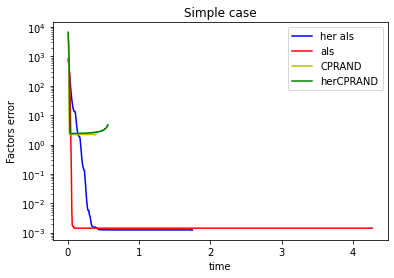

In [41]:
# data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

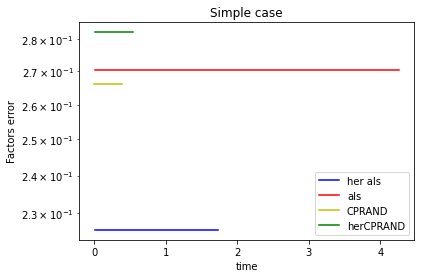

In [42]:
# factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

###### More complicated case

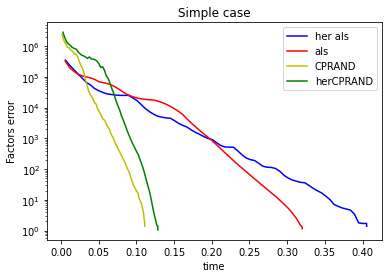

In [35]:
# data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples,scale=True)

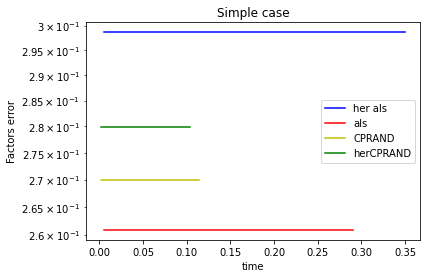

In [36]:
# factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)

# Number of restart

## Simple case with exact error

In [43]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=False)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    weights,factors,it,error,pct=her_CPRAND(t,r,n_samples,exact_err=True,it_max=700,err_it_max=200) 
    list_pct.append(pct)
median(list_pct)

0.48148148148148145

## Simple case with estimated error

In [44]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=False)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    weights,factors,it,error,pct=her_CPRAND(t,r,n_samples,exact_err=False,it_max=700,err_it_max=200) 
    list_pct.append(pct)
median(list_pct)

0.0

## Complicated case with exact error

In [40]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=True)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    weights,factors,it,error,pct=her_CPRAND(t,r,n_samples,exact_err=True,it_max=700,err_it_max=200) 
    list_pct.append(pct)
median(list_pct)

0.04422935555011027

## Complicated case with estimated error

In [39]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=True)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    weights,factors,it,error,pct=her_CPRAND(t,r,n_samples,exact_err=False,it_max=700,err_it_max=200) 
    list_pct.append(pct)
median(list_pct)

0.0

# Real data to do 

In [ ]:
# read csv